<a href="https://colab.research.google.com/github/sb24ragnar/HearHealthPredictor/blob/main/Heart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import shap

In [30]:

import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [31]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
columns = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang',
    'oldpeak', 'slope', 'ca', 'thal', 'target'
]

try:
    heart_df = pd.read_csv(url, names=columns)
    print("✅ Dataset loaded successfully!")
except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    exit()


✅ Dataset loaded successfully!


https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data

In [60]:
dataset_overview = pd.DataFrame({
    "Feature": heart_df.columns,
    "Data Type": heart_df.dtypes.values,
    "Unique Values": heart_df.nunique().values
})

dataset_overview


,Feature,Data Type,Unique Values
0,age,float64,41
1,sex,float64,2
2,cp,float64,4
3,trestbps,float64,50
4,chol,float64,152
5,fbs,float64,2
6,restecg,float64,3
7,thalach,float64,91
8,exang,float64,2
9,oldpeak,float64,40


In [32]:
heart_df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
5,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0
6,62.0,0.0,4.0,140.0,268.0,0.0,2.0,160.0,0.0,3.6,3.0,2.0,3.0,3
7,57.0,0.0,4.0,120.0,354.0,0.0,0.0,163.0,1.0,0.6,1.0,0.0,3.0,0
8,63.0,1.0,4.0,130.0,254.0,0.0,2.0,147.0,0.0,1.4,2.0,1.0,7.0,2
9,53.0,1.0,4.0,140.0,203.0,1.0,2.0,155.0,1.0,3.1,3.0,0.0,7.0,1


In [33]:
# cleaning
heart_df.replace('?', np.nan, inplace=True)
for col in ['ca', 'thal']:
    heart_df[col] = pd.to_numeric(heart_df[col], errors='coerce')

heart_df.fillna(heart_df.median(), inplace=True)

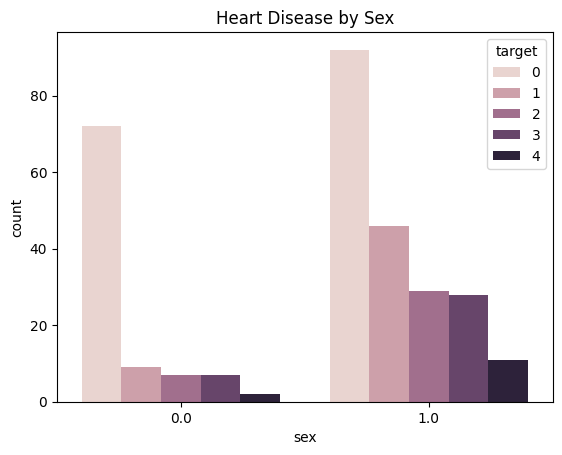

In [34]:
# Sex vs Target
sns.countplot(x='sex', hue='target', data=heart_df)
plt.title('Heart Disease by Sex')
plt.show()

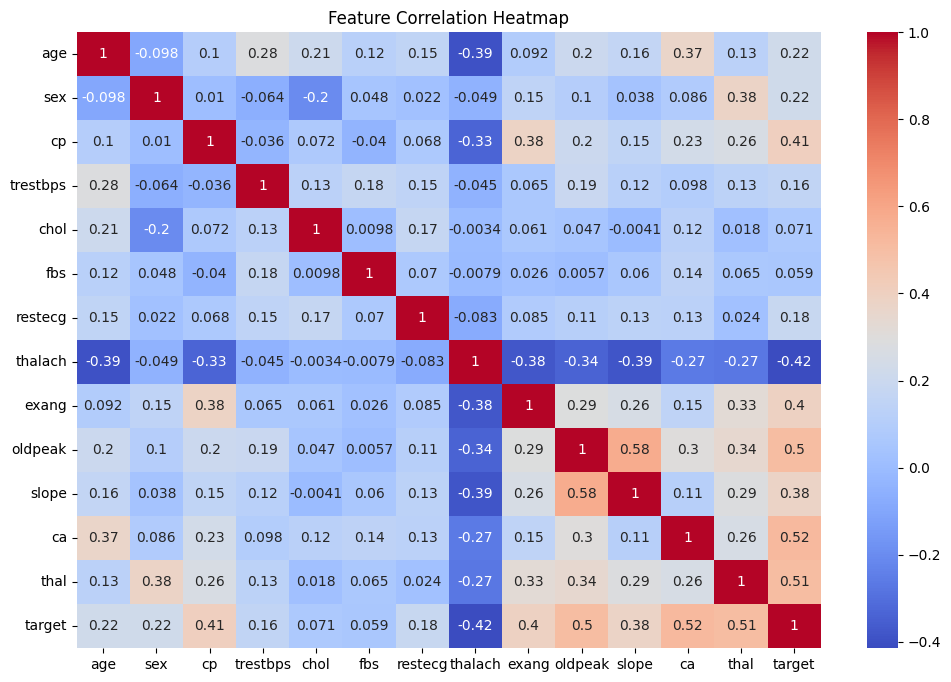

In [35]:
plt.figure(figsize=(12,8))
sns.heatmap(heart_df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [36]:
X = heart_df.drop('target', axis=1)
y = heart_df['target']

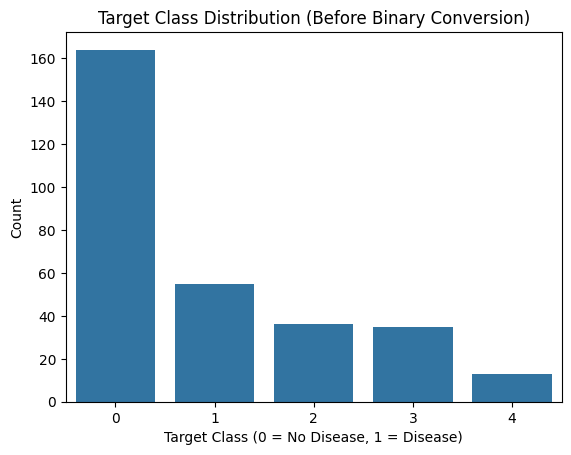

In [37]:
sns.countplot(x=y)
plt.title("Target Class Distribution (Before Binary Conversion)")
plt.xlabel("Target Class (0 = No Disease, 1 = Disease)")
plt.ylabel("Count")
plt.show()

In [38]:
X = heart_df.drop("target", axis=1)
y = heart_df["target"].apply(lambda x: 1 if x > 0 else 0)

In [63]:
numerical_features = [
    'age', 'trestbps', 'chol', 'thalach', 'oldpeak'
]

grouped_stats = heart_df.groupby(y)[numerical_features].agg(
    ['mean', 'std']
).round(2)

grouped_stats


age       trestbps           chol        thalach        oldpeak  \
         mean   std     mean    std    mean    std    mean    std    mean   
target                                                                      
0       52.59  9.51   129.25  16.20  242.64  53.46  158.38  19.20    0.59   
1       56.63  7.94   134.57  18.77  251.47  49.49  139.26  22.59    1.57   

              
         std  
target        
0       0.78  
1       1.30

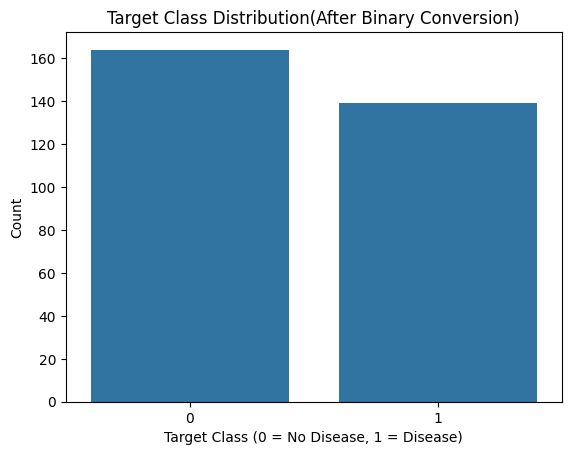

In [39]:
sns.countplot(x=y)
plt.title("Target Class Distribution(After Binary Conversion)")
plt.xlabel("Target Class (0 = No Disease, 1 = Disease)")
plt.ylabel("Count")
plt.show()

Before SMOTE:
target
0    164
1    139
Name: count, dtype: int64


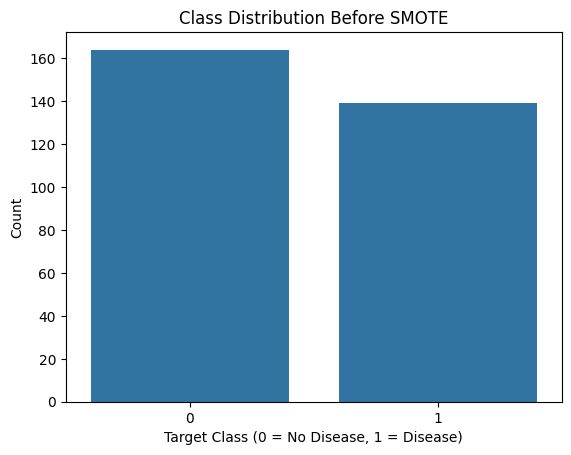

In [40]:
X_encoded = X.copy()

#Class distribution before SMOTE
print("Before SMOTE:")
print(y.value_counts())

sns.countplot(x=y)
plt.title("Class Distribution Before SMOTE")
plt.xlabel("Target Class (0 = No Disease, 1 = Disease)")
plt.ylabel("Count")
plt.show()



After SMOTE:
target
0    164
1    164
Name: count, dtype: int64


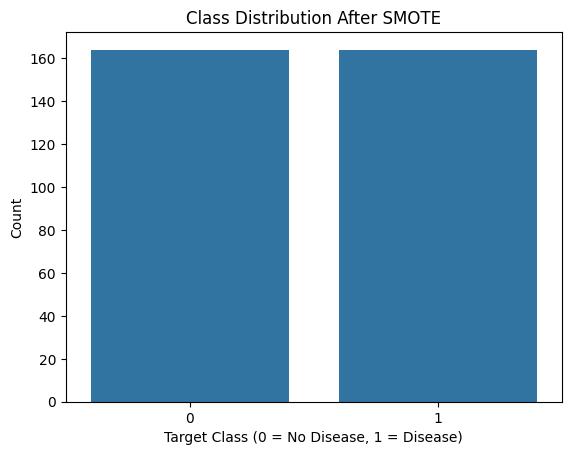

Class 0 count before: 164
Class 1 count before: 139
Class 0 count after: 164
Class 1 count after: 164


In [41]:
categorical_cols = ['cp', 'restecg', 'slope', 'thal', 'sex']

smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_encoded, y)

print("\nAfter SMOTE:")
print(y_balanced.value_counts())

sns.countplot(x=y_balanced)
plt.title("Class Distribution After SMOTE")
plt.xlabel("Target Class (0 = No Disease, 1 = Disease)")
plt.ylabel("Count")
plt.show()

print(f"Class 0 count before: {y.value_counts()[0]}")
print(f"Class 1 count before: {y.value_counts()[1]}")
print(f"Class 0 count after: {y_balanced.value_counts()[0]}")
print(f"Class 1 count after: {y_balanced.value_counts()[1]}")


In [42]:
heart_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [43]:
# Splitting the Data into Training & Test Sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

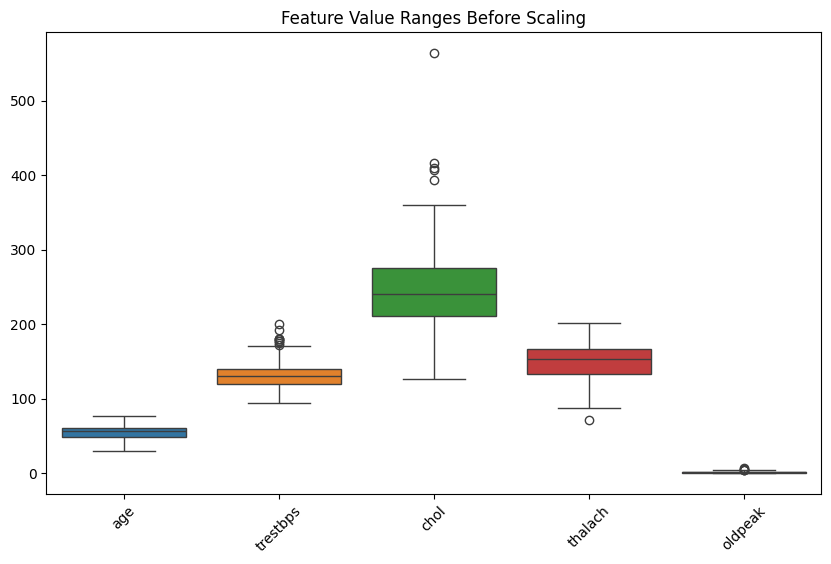

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = ['age','trestbps','chol','thalach','oldpeak']

plt.figure(figsize=(10,6))
sns.boxplot(data=heart_df[numeric_cols])
plt.title("Feature Value Ranges Before Scaling")
plt.xticks(rotation=45)
plt.show()


In [45]:
#Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# scaler file
with open("scaler.pkl", "wb") as scaler_file:
    pickle.dump(scaler, scaler_file)

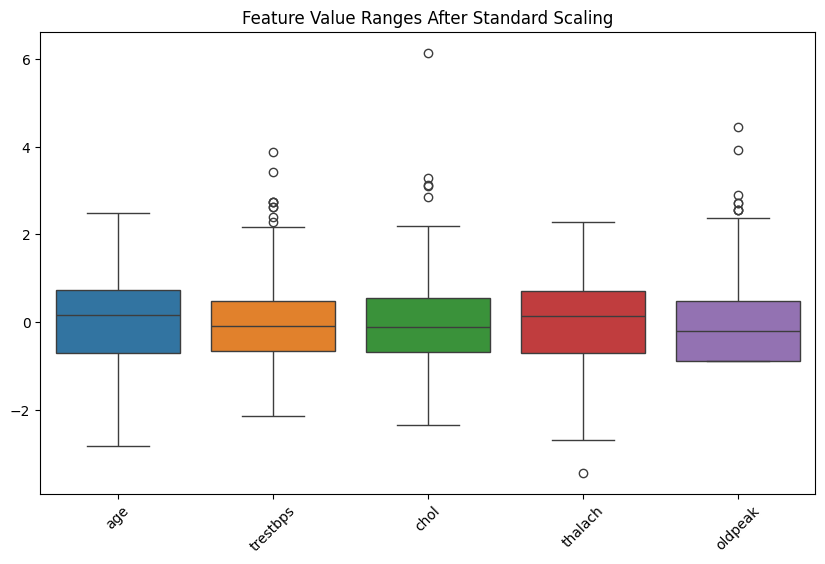

In [46]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled = scaler.fit_transform(heart_df[numeric_cols])
scaled_df = pd.DataFrame(scaled, columns=numeric_cols)

plt.figure(figsize=(10,6))
sns.boxplot(data=scaled_df)
plt.title("Feature Value Ranges After Standard Scaling")
plt.xticks(rotation=45)
plt.show()


In [47]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "CatBoost": CatBoostClassifier(iterations=200, verbose=0, random_state=42),
    "XgBoost" : XGBClassifier( n_estimators=200, max_depth=5, learning_rate=0.1,subsample=0.8,colsample_bytree=0.8,eval_metric="logloss"),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

with open("models.pkl", "wb") as f:
    pickle.dump(models, f)

In [48]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    results.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        #"AUC": round(auc, 4) if auc else "-",
        "Precision": round(classification_report(y_test, y_pred, output_dict=True)["1"]["precision"], 4),
        "Recall": round(classification_report(y_test, y_pred, output_dict=True)["1"]["recall"], 4),
        "F1-Score": round(classification_report(y_test, y_pred, output_dict=True)["1"]["f1-score"], 4)
    })
results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=True)
display(results_df)

,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.8182,0.8182,0.8182,0.8182
1,AdaBoost,0.8333,0.8235,0.8485,0.8358
2,CatBoost,0.8485,0.8485,0.8485,0.8485
3,XgBoost,0.8485,0.8286,0.8788,0.8529
4,Random Forest,0.8485,0.8485,0.8485,0.8485


In [49]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Base XGBoost(for hyper)
xgb = XGBClassifier(
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42
)

# Tuning
param_dist = {
    "n_estimators": [100, 150, 200, 300, 500],
    "max_depth": [3, 4, 5, 6, 8, 10],
    "learning_rate": np.linspace(0.01, 0.3, 10),
    "subsample": [0.6, 0.7, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 1.0],
    "gamma": [0, 1, 5],
    "min_child_weight": [1, 3, 5, 7]
}

# Random Search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=25,
    scoring="f1",
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

#fit
random_search.fit(X_train_scaled, y_train)

print("\nBest Parameters Found:")
print(random_search.best_params_)

#best model
best_xgb = random_search.best_estimator_


y_pred = best_xgb.predict(X_test_scaled)

print("\n XGBoost Performance After Tuning:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


import pickle
with open("xgboost_model.pkl", "wb") as f:
    pickle.dump(best_xgb, f)

print("\nTuned XGBoost model saved as xgboost_model.pkl")


Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:13:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best Parameters Found:
{'subsample': 0.6, 'n_estimators': 150, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': np.float64(0.10666666666666666), 'gamma': 5, 'colsample_bytree': 0.6}

 XGBoost Performance After Tuning:
              precision    recall  f1-score   support

           0       0.88      0.85      0.86        33
           1       0.85      0.88      0.87        33

    accuracy                           0.86        66
   macro avg       0.86      0.86      0.86        66
weighted avg       0.86      0.86      0.86        66

Accuracy: 0.8636363636363636

Tuned XGBoost model saved as xgboost_model.pkl


In [50]:
y_pred_xgb = best_xgb.predict(X_test_scaled)
print("\nXGBoost Model Performance:")
print(classification_report(y_test, y_pred_xgb))
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")


XGBoost Model Performance:
              precision    recall  f1-score   support

           0       0.88      0.85      0.86        33
           1       0.85      0.88      0.87        33

    accuracy                           0.86        66
   macro avg       0.86      0.86      0.86        66
weighted avg       0.86      0.86      0.86        66

Accuracy: 0.8636


In [51]:
import pickle
import numpy as np
import pandas as pd

# Loading model and scaler
model = pickle.load(open("xgboost_model.pkl", "rb"))
scaler = pickle.load(open("scaler.pkl", "rb"))

sample_data = {
    'age': 67,
    'sex': 1,
    'cp': 1,
    'trestbps': 160,
    'chol': 286,
    'fbs': 0,
    'restecg': 2.0,
    'thalach': 108,
    'exang': 1,
    'oldpeak': 1.5,
    'slope': 2,
    'ca': 3,
    'thal': 3
}

# Ensure the DataFrame has the same columns and order as X_train
feature_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
df = pd.DataFrame([sample_data], columns=feature_names)


# Scale input
scaled = scaler.transform(df)

# Predict
pred = model.predict(scaled)[0]

print("Prediction:", pred)


Prediction: 1
